In [2]:
import numpy as np
import math
from random import random
from scipy.optimize import minimize

from qiskit import *
from qiskit.circuit.library.standard_gates import U2Gate
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import NumPyEigensolver

# For H1

In [3]:
def hamiltonian_operator(a, b):
    """
    Creates a*I + b*Z pauli sum 
    that will be our Hamiltonian operator.
    
    """
    pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": a}, "label": "I"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "Z"},
                   ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)

In [4]:
a, b = -0.218291, 0.218291
H = hamiltonian_operator(a, b)

In [5]:
exact_result = NumPyEigensolver(H).run()
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -0.436582


In [6]:
def vqe_circuit(parameters, measure):
    """
    Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. E.g. 'Z' stands for Z measurement.
    :return: quantum circuit.
    """
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    q = circuit.qregs[0]
    circuit.rx(parameters[0], q[0])
    circuit.ry(parameters[1], q[0])


    # measurement
    if measure == 'Z':
        circuit.measure(q[0], c[0])
    else:
        raise ValueError('Not valid input for measurement: input should be "Z"')

    return circuit


In [7]:
def quantum_module(parameters, measure):
    # measure
    if measure == 'I':
        return 1
    elif measure == 'Z':
        circuit = vqe_circuit(parameters, 'Z')
    else:
        raise ValueError('Not valid input for measurement: input should be "I" or "Z"')
    
    shots = 1024
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # expectation value estimation from counts
    expectation_value = 0
    for measure_result in counts:
        sign = +1
        if measure_result == '1':
            sign = -1
        expectation_value += sign * counts[measure_result] / shots
        
    return expectation_value

In [8]:
def pauli_operator_to_dict(pauli_operator):
    """
    :param pauli_operator: qiskit's WeightedPauliOperator
    :return: a dict in the desired form.
    """
    d = pauli_operator.to_dict()
    paulis = d['paulis']
    paulis_dict = {}

    for x in paulis:
        label = x['label']
        coeff = x['coeff']['real']
        paulis_dict[label] = coeff

    return paulis_dict
pauli_dict = pauli_operator_to_dict(H)

In [9]:
def vqe(parameters):
        
    # quantum_modules
    quantum_module_I = pauli_dict['I'] * quantum_module(parameters, 'I')
    quantum_module_Z = pauli_dict['Z'] * quantum_module(parameters, 'Z')
    
    # summing the measurement results
    classical_adder = quantum_module_I + quantum_module_Z 
    return classical_adder

In [10]:
parameters_array = np.array([np.pi, np.pi]) #initals guess
tol = 1e-3 # tolerance for optimization precision.

vqe_result = minimize(vqe, parameters_array, method="COBYLA", tol=tol)
print('The exact ground state energy is: {}'.format(reference_energy))
print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))

The exact ground state energy is: -0.436582
The estimated ground state energy from VQE algorithm is: -0.43615565039062504


# For H2

In [3]:
def hamiltonian_operator(a, b, c, d, e):
    """
    Creates a*II + b*IZ + c*ZI + d*XX + e*YY pauli sum
    that will be our Hamiltonian operator.
   
    """
    pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": a}, "label": "II"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "IZ"},
                   {"coeff": {"imag": 0.0, "real": c}, "label": "ZI"},
                   {"coeff": {"imag": 0.0, "real": d}, "label": "XX"},
                   {"coeff": {"imag": 0.0, "real": e}, "label": "YY"}
                   ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)

In [4]:
a, b, c, d, e = 5.906709 , 0.218291, -6.125 ,-2.143304 ,-2.143304
H = hamiltonian_operator(a, b, c, d, e)

In [ ]:
exact_result = NumPyEigensolver(H).run()
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

In [1]:
def vqe_circuit(parameters, measure):
    """Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. E.g. 'IZ' stands for Z0 measurement,  'XX' stands for X0X1 measurement.
    :return: quantum circuit.
    """
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    circuit.x(0)
    circuit.ry(parameters[0],q[1])
    circuit.cx(q[1], q[0])
    
    
    
    # measurement
    if measure == 'IZ':
        circuit.barrier(q[0],q[1])
        circuit.measure(q[0], c[0])
    elif measure == 'ZI':
        circuit.barrier(q[0],q[1])
        circuit.measure(q[1], c[1])
    elif measure == 'XX':
        circuit.barrier(q[0],q[1])
        circuit.u(np.pi/2, 0, np.pi, q[0])
        circuit.u(np.pi/2, 0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'YY':
        circuit.barrier(q[0],q[1])
        circuit.u(np.pi/2, 0, np.pi/2, q[0])
        circuit.u(np.pi/2,0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    else:
        raise ValueError('Not valid input for measurement: input should be "IZ" or "ZI" or "XX" or "YY"')
    
    return circuit


In [2]:
def quantum_module(parameters, measure):
    # measure
    if measure == 'II':
        return 1
    elif measure == 'IZ':
        circuit = vqe_circuit(parameters, 'IZ')
    elif measure == 'ZI':
        circuit = vqe_circuit(parameters, 'ZI')
    elif measure == 'XX':
        circuit = vqe_circuit(parameters, 'XX')
    elif measure == 'YY':
        circuit = vqe_circuit(parameters, 'YY')
    else:
        raise ValueError('Not valid input for measurement: input should be "IZ" or "ZI" or "XX" or "YY"')
   
    shots = 65536
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    # expectation value estimation from counts
    expectation_value = 0
    for measure_result in counts:
        sign = -1
        if (measure_result == '00') or (measure_result == '11'):
             sign = +1
        expectation_value += sign * counts[measure_result] / shots
        
    return expectation_value



In [3]:
def pauli_operator_to_dict(pauli_operator):
    """
    from WeightedPauliOperator return a dict:
    {II: 5.906709 , IZ: 0.218291, ZI: -6.125, XX: -2.143304, YY: -2.143304}.
    :param pauli_operator: qiskit's WeightedPauliOperator
    :return: a dict in the desired form.
    """
    d = pauli_operator.to_dict()
    paulis = d['paulis']
    paulis_dict = {}
    
    for x in paulis:
        label = x['label']
        coeff = x['coeff']['real']
        paulis_dict[label] = coeff
    return paulis_dict
pauli_dict = pauli_operator_to_dict(H)

NameError: name 'H' is not defined

In [ ]:
def vqe(parameters):
       
    # quantum_modules
    quantum_module_II = pauli_dict['II'] * quantum_module(parameters, 'II')
    quantum_module_IZ = pauli_dict['IZ'] * quantum_module(parameters, 'IZ')
    quantum_module_ZI = pauli_dict['ZI'] * quantum_module(parameters, 'ZI')
    quantum_module_XX = pauli_dict['XX'] * quantum_module(parameters, 'XX')
    quantum_module_YY = pauli_dict['YY'] * quantum_module(parameters, 'YY')
   
    # summing the measurement results
    classical_adder = quantum_module_II + quantum_module_IZ+ quantum_module_ZI + quantum_module_XX + quantum_module_YY
    energy = classical_adder*(1-2*((pow(parameters[2],2)/parameters[3])*(math.exp(-2*parameters[3]*11.45))) - 4*((11.45*pow(parameters[3],4)/parameters[3])*(math.exp(-4*parameters[2]*11.45))))
    return energy


In [ ]:
parameters_array = np.array([-np.pi, np.pi, 100, 100])
tol = 1e-5 # tolerance for optimization precision.
a= {"maxiter" : 100}
vqe_result = minimize(vqe, parameters_array, method="COBYLA", tol=tol,options = a)
print('The exact ground state energy is: {}'.format(reference_energy))
print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))
print("\nThe optimal parameter theta is : {} ".format(vqe_result.x))

# for H3

In [18]:
def hamiltonian_operator(a, b, c, d, e, f, g, h):
    """
    Creates a*III + b*IIZ + c*IZI + d*ZII + e*IXX + f*IYY + g*XXI + h*YYI pauli sum
    that will be our Hamiltonian operator.
   
    """
    pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": a}, "label": "III"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "IIZ"},
                   {"coeff": {"imag": 0.0, "real": c}, "label": "IZI"},
                   {"coeff": {"imag": 0.0, "real": d}, "label": "ZII"},
                   {"coeff": {"imag": 0.0, "real": e}, "label": "IXX"},
                   {"coeff": {"imag": 0.0, "real": f}, "label": "IYY"},
                   {"coeff": {"imag": 0.0, "real": g}, "label": "XXI"},
                   {"coeff": {"imag": 0.0, "real": h}, "label": "YYI"},
                   ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)

In [19]:
a, b, c, d, e, f, g, h = 15.531709, 0.218291, -6.125, -9.625, -2.143304, -2.143304, -3.913119, -3.913119
H = hamiltonian_operator(a, b, c, d, e, f, g, h)

In [20]:
exact_result = NumPyEigensolver(H).run()
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -2.045672287677095


In [21]:
def vqe_circuit(parameters, measure):
    """Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. E.g. 'IIZ' stands for Z0 measurement,  'XXI' stands for X1X2 measurement.
    :return: quantum circuit.
    """
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circuit = QuantumCircuit(q, c)
    
#     circuit.x(0)
#     circuit.ry(parameters[0],q[1])
#     circuit.ry(parameters[1],q[2])
#     circuit.cx(q[2], q[0])
#     circuit.cx(q[0], q[1])
#     circuit.barrier(q[0], q[1], q[2])
#     circuit.ry(-parameters[0], q[1])
#     circuit.cx(q[0], q[1])
#     circuit.cx(q[1], q[0])
    circuit.x(2)
    circuit.ry(parameters[0],q[1])
    circuit.cx(q[1], q[2])
    circuit.barrier(q[0], q[1], q[2])
    circuit.ry(parameters[1], q[0])
    circuit.cx(q[1], q[0])
    circuit.ry(-parameters[1], q[0])
    circuit.cx(q[1], q[0])
    circuit.cx(q[0], q[1])
    # measurement
    if measure == 'IIZ':
        circuit.barrier(q[0],q[1],q[2])
        circuit.measure(q[0], c[0])
    elif measure == 'IZI':
        circuit.barrier(q[0],q[1],q[2])
        circuit.measure(q[1], c[1])
    elif measure == 'ZII':
        circuit.barrier(q[0],q[1],q[2])
        circuit.measure(q[2], c[2])
    elif measure == 'IXX':
        circuit.barrier(q[0],q[1],q[2])
        circuit.u(np.pi/2, 0, np.pi, q[0])
        circuit.u(np.pi/2, 0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'IYY':
        circuit.barrier(q[0],q[1],q[2])
        circuit.u(np.pi/2, 0, np.pi/2, q[0])
        circuit.u(np.pi/2,0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'XXI':
        circuit.barrier(q[0],q[1],q[2])
        circuit.u(np.pi/2, 0, np.pi, q[1])
        circuit.u(np.pi/2, 0, np.pi, q[2])
        circuit.measure(q[1], c[1])
        circuit.measure(q[2], c[2])
    elif measure == 'YYI':
        circuit.barrier(q[0],q[1],q[2])
        circuit.u(np.pi/2, 0, np.pi/2, q[1])
        circuit.u(np.pi/2,0, np.pi/2, q[2])
        circuit.measure(q[1], c[1])
        circuit.measure(q[2], c[2])
    else:
        raise ValueError('Not valid input for measurement')
    
    return circuit


In [22]:
def quantum_module(parameters, measure):
    # measure
    if measure == 'III':
        return 1
    elif measure == 'IIZ':
        circuit = vqe_circuit(parameters, 'IIZ')
    elif measure == 'IZI':
        circuit = vqe_circuit(parameters, 'IZI')
    elif measure == 'ZII':
        circuit = vqe_circuit(parameters, 'ZII')
    elif measure == 'IXX':
        circuit = vqe_circuit(parameters, 'IXX')
    elif measure == 'IYY':
        circuit = vqe_circuit(parameters, 'IYY')
    elif measure == 'XXI':
        circuit = vqe_circuit(parameters, 'XXI')
    elif measure == 'YYI':
        circuit = vqe_circuit(parameters, 'YYI')
    else:
        raise ValueError('Not valid input for measurement: input should be "III" or "IIZ" or "IZI" or "ZII" or "IXX" or "IYY" or "XXI" or "YYI"')
   
    shots = 65536
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    # expectation value estimation from counts
    expectation_value = 0
    for measure_result in counts:
        sign = -1
        if (measure_result == '000') or (measure_result == '011')  or (measure_result == '101')  or (measure_result == '110'):
             sign = +1
        expectation_value += sign * counts[measure_result] / shots
        
    return expectation_value

In [23]:
def pauli_operator_to_dict(pauli_operator):
    """
    from WeightedPauliOperator return a dict:
    {III: 15.531709, IIZ: 0.218291, IZI: -6.125, ZII: -9.625, IXX: -2.143304, IYY: -2.143304, XXI: -3.913119, YYI: -3.913119}.
    :param pauli_operator: qiskit's WeightedPauliOperator
    :return: a dict in the desired form.
    """
    d = pauli_operator.to_dict()
    paulis = d['paulis']
    paulis_dict = {}
    
    for x in paulis:
        label = x['label']
        coeff = x['coeff']['real']
        paulis_dict[label] = coeff
    return paulis_dict
pauli_dict = pauli_operator_to_dict(H)

In [24]:
def vqe(parameters):
       
    # quantum_modules
    quantum_module_III = pauli_dict['III'] * quantum_module(parameters, 'III')
    quantum_module_IIZ = pauli_dict['IIZ'] * quantum_module(parameters, 'IIZ')
    quantum_module_IZI = pauli_dict['IZI'] * quantum_module(parameters, 'IZI')
    quantum_module_ZII = pauli_dict['ZII'] * quantum_module(parameters, 'ZII')
    quantum_module_IXX = pauli_dict['IXX'] * quantum_module(parameters, 'IXX')
    quantum_module_IYY = pauli_dict['IYY'] * quantum_module(parameters, 'IYY')
    quantum_module_XXI = pauli_dict['XXI'] * quantum_module(parameters, 'XXI')
    quantum_module_YYI = pauli_dict['YYI'] * quantum_module(parameters, 'YYI')
   
    # summing the measurement results
    classical_adder = quantum_module_III + quantum_module_IIZ + quantum_module_IZI + quantum_module_ZII + quantum_module_IXX  + quantum_module_IYY + quantum_module_XXI + quantum_module_YYI
    return classical_adder


In [25]:
parameters_array = np.array([np.pi/2,np.pi/2])
tol = 1e-5 # tolerance for optimization precision.
a= {"maxiter" : 500}
vqe_result = minimize(vqe, parameters_array, method="COBYLA", tol=tol,options = a)
print('The exact ground state energy is: {}'.format(reference_energy))
print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))
print("\nThe optimal parameter theta is : {} ".format(vqe_result.x))

The exact ground state energy is: -2.045672287677095
The estimated ground state energy from VQE algorithm is: -2.045083450592042

The optimal parameter theta is : [2.83538614 1.20159288] 


In [26]:
#trying to use qiskit optimizer
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)
parameters_array = np.array([np.pi/2, np.pi/2])

vqe_results = optimizer.optimize(num_vars=2, objective_function=vqe, initial_point=parameters_array)
print(vqe_results[1])

-1.991915398345948


In [27]:
# define range for input
r_min, r_max = -np.pi, np.pi
# sample input range uniformly at 0.1 increments
inputs = np.arange(r_min, r_max, 0.025)
# summarize some of the input domain
print(inputs[:10])
len(inputs)

[-3.14159265 -3.11659265 -3.09159265 -3.06659265 -3.04159265 -3.01659265
 -2.99159265 -2.96659265 -2.94159265 -2.91659265]


252

In [28]:
temp=[]
for i in inputs:
    temp.append([i,i])
temp=np.array(temp)

In [29]:
results = []
for i in range(252):
    results.append(vqe(temp[i]))
# results = np.arange(vqe(inputs))
# summarize some of the results
print(results[:10])
len(results)

[12.246509516845702, 11.83590287704468, 11.377773450164792, 10.949885692474366, 10.526894006713865, 10.066175351409914, 9.54155439251709, 9.157875618530271, 8.626957428771973, 8.173713547729493]


252

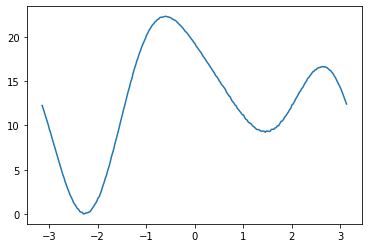

In [30]:
from matplotlib import pyplot
pyplot.plot(inputs, results)
# show the plot
pyplot.show()

# for H4

In [3]:
def hamiltonian_operator(a, b, c, d, e, f, g, h, i, j, k):
    """
    Creates a*IIII + b*IIIZ + c*IIZI + d*IZII + e*ZIII + f*IIXX + g*IIYY + h*IXXI + i*IYYI + j*XXII+ k*YYII pauli sum
    that will be our Hamiltonian operator.
   
    """
    pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": a}, "label": "IIII"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "IIIZ"},
                   {"coeff": {"imag": 0.0, "real": c}, "label": "IIZI"},
                   {"coeff": {"imag": 0.0, "real": d}, "label": "IZII"},
                   {"coeff": {"imag": 0.0, "real": e}, "label": "ZIII"},
                   {"coeff": {"imag": 0.0, "real": f}, "label": "IIXX"},
                   {"coeff": {"imag": 0.0, "real": g}, "label": "IIYY"},
                   {"coeff": {"imag": 0.0, "real": h}, "label": "IXXI"},
                   {"coeff": {"imag": 0.0, "real": i}, "label": "IYYI"},
                   {"coeff": {"imag": 0.0, "real": j}, "label": "XXII"},
                   {"coeff": {"imag": 0.0, "real": k}, "label": "YYII"},
                   ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)

In [4]:
a, b, c, d, e, f, g, h, i, j, k = 28.656709, 0.218291, -6.125, -9.625, -13.125, -2.143304, -2.143304, -3.91311, -3.91311, -5.670648, -5.670648
H = hamiltonian_operator(a, b, c, d, e, f, g, h, i, j, k)

In [5]:
exact_result = NumPyEigensolver(H).run()
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -2.1439801978179207


In [6]:
def vqe_circuit(parameters, measure):
    """Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. E.g. 'IIIZ' stands for Z0 measurement,  'IXXI' stands for X1X2 measurement.
    :return: quantum circuit.
    """
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    circuit = QuantumCircuit(q, c)
    
    circuit.x(3)
    circuit.ry(parameters[0],q[2])
    circuit.cx(q[2], q[3])
    circuit.barrier(q[0], q[1], q[2], q[3])
    circuit.ry(parameters[1], q[1])
    circuit.cx(q[2], q[1])
    circuit.ry(-parameters[1], q[1])
    circuit.cx(q[2], q[1])
    circuit.cx(q[1], q[2])
    circuit.barrier(q[0], q[1], q[2], q[3])
    circuit.ry(parameters[2], q[0])
    circuit.cx(q[1], q[0])
    circuit.ry(-parameters[2],q[0])
    circuit.cx(q[1], q[0])
    circuit.cx(q[0], q[1])
    # measurement
    if measure == 'IIIZ':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.measure(q[0], c[0])
    elif measure == 'IIZI':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.measure(q[1], c[1])
    elif measure == 'IZII':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.measure(q[2], c[2])
    elif measure == 'ZIII':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.measure(q[3], c[3])
    elif measure == 'IIXX':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.u(np.pi/2, 0, np.pi, q[0])
        circuit.u(np.pi/2, 0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'IIYY':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.u(np.pi/2, 0, np.pi/2, q[0])
        circuit.u(np.pi/2,0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'IXXI':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.u(np.pi/2, 0, np.pi, q[1])
        circuit.u(np.pi/2, 0, np.pi, q[2])
        circuit.measure(q[1], c[1])
        circuit.measure(q[2], c[2])
    elif measure == 'IYYI':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.u(np.pi/2, 0, np.pi/2, q[1])
        circuit.u(np.pi/2,0, np.pi/2, q[2])
        circuit.measure(q[1], c[1])
        circuit.measure(q[2], c[2])
    elif measure == 'XXII':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.u(np.pi/2, 0, np.pi, q[2])
        circuit.u(np.pi/2, 0, np.pi, q[3])
        circuit.measure(q[2], c[2])
        circuit.measure(q[3], c[3])
    elif measure == 'YYII':
        circuit.barrier(q[0], q[1], q[2], q[3])
        circuit.u(np.pi/2, 0, np.pi/2, q[2])
        circuit.u(np.pi/2,0, np.pi/2, q[3])
        circuit.measure(q[2], c[2])
        circuit.measure(q[3], c[3])
    else:
        raise ValueError('Not valid input for measurement')
    
    return circuit


In [7]:
def quantum_module(parameters, measure):
    # measure
    if measure == 'IIII':
        return 1
    elif measure == 'IIIZ':
        circuit = vqe_circuit(parameters, 'IIIZ')
    elif measure == 'IIZI':
        circuit = vqe_circuit(parameters, 'IIZI')
    elif measure == 'IZII':
        circuit = vqe_circuit(parameters, 'IZII')
    elif measure == 'ZIII':
        circuit = vqe_circuit(parameters, 'ZIII')
    elif measure == 'IIXX':
        circuit = vqe_circuit(parameters, 'IIXX')
    elif measure == 'IIYY':
        circuit = vqe_circuit(parameters, 'IIYY')
    elif measure == 'IXXI':
        circuit = vqe_circuit(parameters, 'IXXI')
    elif measure == 'IYYI':
        circuit = vqe_circuit(parameters, 'IYYI')
    elif measure == 'XXII':
        circuit = vqe_circuit(parameters, 'XXII')
    elif measure == 'YYII':
        circuit = vqe_circuit(parameters, 'YYII')
    else:
        raise ValueError('Not valid input for measurement')
   
    shots = 65536
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    # expectation value estimation from counts
    expectation_value = 0
    for measure_result in counts:
        sign = -1
        if (measure_result == '0000') or (measure_result == '0011')  or (measure_result == '0101')  or (measure_result == '0110') or (measure_result == '1001') or (measure_result == '1010') or (measure_result == '1100') or (measure_result == '1111'):
             sign = +1
        expectation_value += sign * counts[measure_result] / shots
        
    return expectation_value

In [8]:
def pauli_operator_to_dict(pauli_operator):
   
    d = pauli_operator.to_dict()
    paulis = d['paulis']
    paulis_dict = {}
    
    for x in paulis:
        label = x['label']
        coeff = x['coeff']['real']
        paulis_dict[label] = coeff
    return paulis_dict
pauli_dict = pauli_operator_to_dict(H)

In [9]:
def vqe(parameters):
       
    # quantum_modules
    quantum_module_IIII = pauli_dict['IIII'] * quantum_module(parameters, 'IIII')
    quantum_module_IIIZ = pauli_dict['IIIZ'] * quantum_module(parameters, 'IIIZ')
    quantum_module_IIZI = pauli_dict['IIZI'] * quantum_module(parameters, 'IIZI')
    quantum_module_IZII = pauli_dict['IZII'] * quantum_module(parameters, 'IZII')
    quantum_module_ZIII = pauli_dict['ZIII'] * quantum_module(parameters, 'ZIII')
    quantum_module_IIXX = pauli_dict['IIXX'] * quantum_module(parameters, 'IIXX')
    quantum_module_IIYY = pauli_dict['IIYY'] * quantum_module(parameters, 'IIYY')
    quantum_module_IXXI = pauli_dict['IXXI'] * quantum_module(parameters, 'IXXI')
    quantum_module_IYYI = pauli_dict['IYYI'] * quantum_module(parameters, 'IYYI')
    quantum_module_XXII = pauli_dict['XXII'] * quantum_module(parameters, 'XXII')
    quantum_module_YYII = pauli_dict['YYII'] * quantum_module(parameters, 'YYII')
   
    # summing the measurement results
    classical_adder = quantum_module_IIII + quantum_module_IIIZ + quantum_module_IIZI + quantum_module_IZII + quantum_module_ZIII + quantum_module_IIXX  + quantum_module_IIYY + quantum_module_IXXI + quantum_module_IYYI + quantum_module_XXII + quantum_module_YYII 
    return classical_adder


In [13]:
parameters_array = np.array([np.pi,np.pi/2, np.pi/2])
tol = 1e-5 # tolerance for optimization precision.
a= {"maxiter" : 100}
vqe_result = minimize(vqe, parameters_array, method="COBYLA", tol=tol,options = a)
print('The exact ground state energy is: {}'.format(reference_energy))
print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))
print("\nThe optimal parameter theta is : {} ".format(vqe_result.x))

The exact ground state energy is: -2.1439801978179207
The estimated ground state energy from VQE algorithm is: -2.1416317929992683

The optimal parameter theta is : [2.99158157 1.41132981 1.17018177] 


In [14]:
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=100, tol=0.001)
parameters_array = np.array([np.pi, np.pi/2, np.pi/2])

vqe_results = optimizer.optimize(num_vars=3, objective_function=vqe, initial_point=parameters_array)
print(vqe_results[1])

-2.032787969848634
